In [1]:
import scipy as sp
import numpy as np
import numpy.random as rd
import scipy.linalg as LA
import scipy.sparse.linalg as sLA
import time
import warnings

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from RMG import RMG

In [3]:
def lambda_funct (evlA,evlB,T,k=0):
    tt = np.all(evlA==0) or np.all(evlB==0)
    if T!=0:
        return evlA+sp.special.lambertw(evlB*T*np.exp(-evlA*T),k=k)/T
    elif T==0 and tt:
        return (evlA+evlB)

In [22]:
#EIGENVALUES COMPUTATION
def comp_eig(M, sparse='no',symm='no'):
    evl=0
    if symm == 'no':
        if sparse =='no':
            evl = LA.eigvals(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigs(mm,k=1,which='LR',return_eigenvectors=False)
    if symm == 'yes':
        if sparse =='no':
            evl = LA.eigvalsh(M)
        if sparse =='yes':
            mm = sp.sparse.csr_matrix(M)
            evl = sLA.eigsh(mm,k=1,which='LA',return_eigenvectors=False)
    return evl

def comp_eig_delay(A, B, T, symm='no', k=0):
    if np.all(A == 0):
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (0,evlB,T,k=k)
    else:
        evlA = comp_eig(A, sparse='no',symm=symm)
        evlB = comp_eig(B, sparse='no',symm=symm)
        return lambda_funct (evlA,evlB,T,k=k)
    
def eig_double (A,B,T,symm='no',which='a'):
    if which=='a':
        evlA, evec = LA.eig(A)
        rho = np.sum(evec*(B@evec), axis=0)/np.sum((evec*evec), axis=0)
        lamb = lambda_funct (evlA,rho,T)
        return lamb
    if which=='b':
        evlB, evec = LA.eig(B)
        rho = np.sum(evec*(A@evec), axis=0)/np.sum((evec*evec), axis=0)
        lamb = lambda_funct (rho,evlB,T)
        return lamb

In [4]:
color = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd','#8c564b','#e377c2','#7f7f7f','#bcbd22','#17becf']

In [24]:
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'over': 'warn', 'under': 'ignore', 'invalid': 'ignore'}

# Distributions

In [117]:
S = 1000       #species - shape matrix
C = 0.1        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.1    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

In [118]:
Tvec = [0.2,0.5,1.,2.]

#circle
theta = np.linspace(0, 2*np.pi, 2000)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)
#ellipse
E = np.sqrt(2/np.pi)*sigma
a = complexity*(1+(E/sigma)**2)
b = complexity*(1-(E/sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*np.cos(theta))**2)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

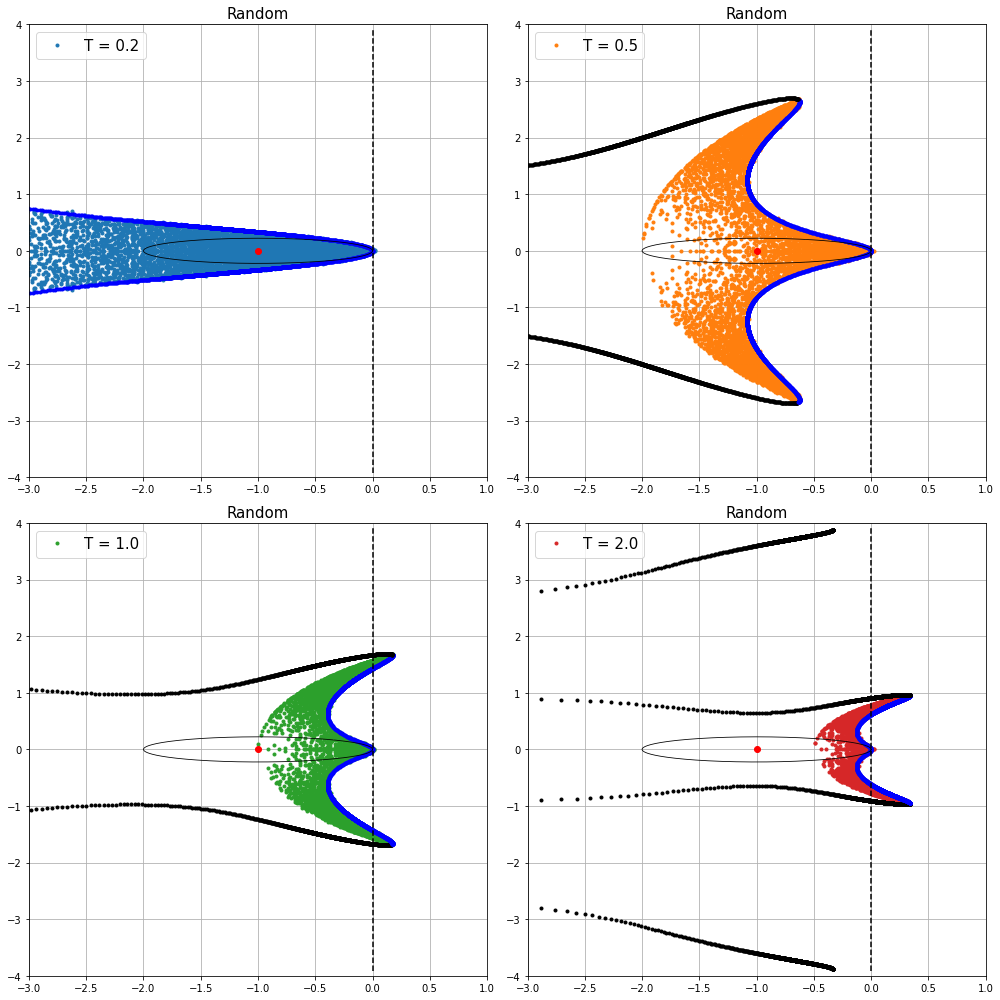

In [121]:
num=5

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,14)

Class.sigma = 0.1*np.pi/(np.pi+2)
Class.mix_matrix()
for j,T in enumerate(Tvec):
    plt.subplot(2,2,j+1)
    evl  = comp_eig_delay(0,Class.M,T)
    plt.plot(evl.real, evl.imag,'.',color=color[j],label=f'T = {T}')
    for k in range(num):
        Class.mix_matrix()
        evl  = comp_eig_delay(0,Class.M,T)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        
    for k in [-1,0,1]:
        f = lambda_funct (np.zeros(len(x)),x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),T,k=k)
        if k==0:
            plt.plot(f.real,f.imag,'b.')
        else:
            plt.plot(f.real,f.imag,'k.')
    plt.plot(-Class.d,0,'or')
    plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
    plt.axvline(0,0.01,0.99,ls='--',c='k')
    plt.ylim(-3,3)
    plt.xlim(-3,1)
    plt.title("Random",fontsize=15)
    plt.grid()
    plt.legend(fontsize=15)


fig.tight_layout()
plt.show(fig)

In [98]:
k_vec = [-2,-1,0,1,2]

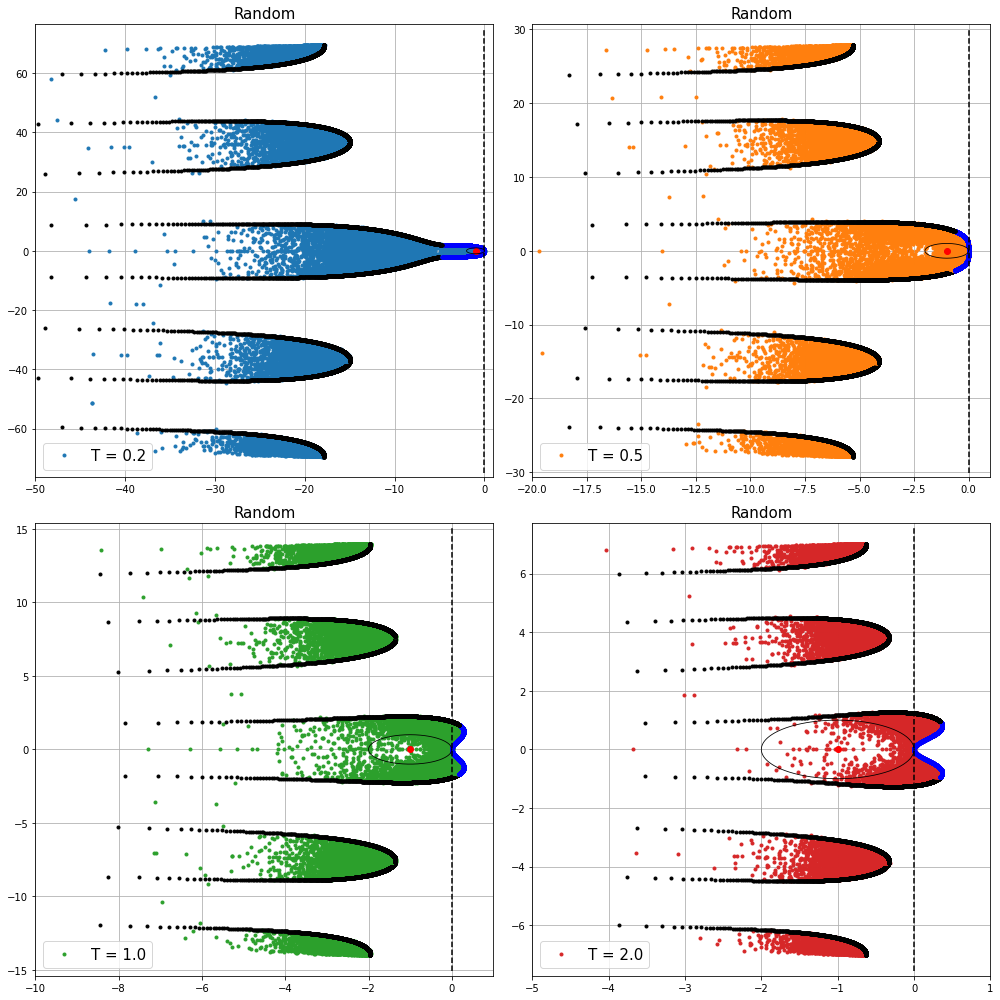

In [99]:
num=5

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,14)

Class.sigma = 0.1
Class.ran_matrix()
lm = [-50,-20,-10,-5]
for j,T in enumerate(Tvec):
    plt.subplot(2,2,j+1)
    for kk in k_vec:
        evl  = comp_eig_delay(0,Class.M,T,k=kk)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        for k in range(num):
            Class.ran_matrix()
            evl  = comp_eig_delay(0,Class.M,T,k=kk)
            plt.plot(evl.real, evl.imag,'.',color=color[j])
        f = lambda_funct (np.zeros(len(x)),x-Class.d+1.j*y,T,k=kk)
        if kk==0:
            plt.plot(f.real,f.imag,'b.')
        else:
            plt.plot(f.real,f.imag,'k.')
    plt.plot(-Class.d,0,'or')
    plt.plot(x-Class.d,y,'-k',linewidth=0.8)
    plt.axvline(0,0.01,0.99,ls='--',c='k')
    plt.xlim(left=lm[j],right=1)
    plt.title("Random",fontsize=15)
    plt.grid()
    plt.legend(labels=[f'T = {T}'],fontsize=15)


fig.tight_layout()
plt.show(fig)

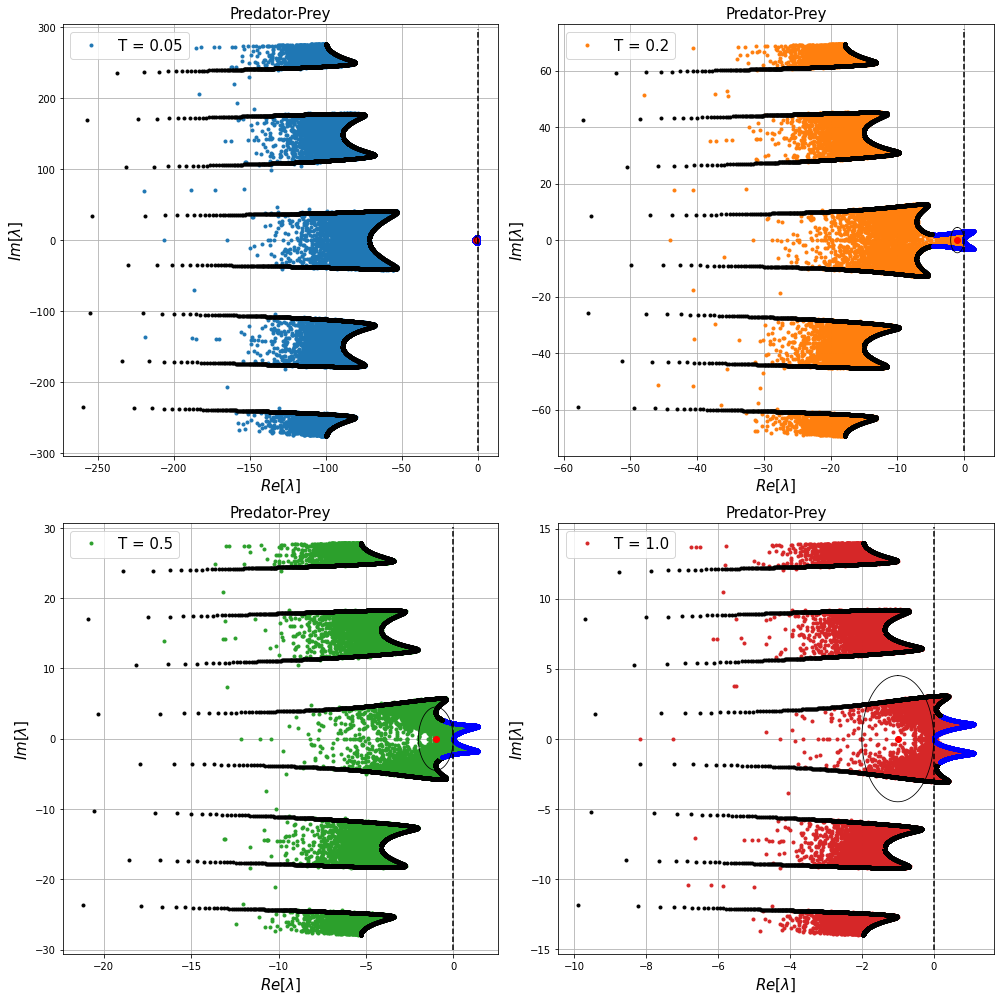

In [100]:
num=5

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,14)

Class.sigma = 0.1*(np.pi/(np.pi-2))
Class.pp_matrix()
for j,T in enumerate([0.05]+Tvec[:-1]):
    plt.subplot(2,2,j+1)
    for kk in k_vec:
        evl  = comp_eig_delay(0,Class.M,T,k=kk)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        for k in range(num):
            Class.pp_matrix()
            evl  = comp_eig_delay(0,Class.M,T,k=kk)
            plt.plot(evl.real, evl.imag,'.',color=color[j])
        f = lambda_funct (np.zeros(len(x)),y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),T,k=kk)
        if kk==0:
            plt.plot(f.real,f.imag,'b.')
        else:
            plt.plot(f.real,f.imag,'k.')
    plt.plot(-Class.d,0,'or')
    plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
    plt.axvline(0,0.01,0.99,ls='--',c='k')
    plt.xlabel(f'$Re[\lambda]$',fontsize=15)
    plt.ylabel(f'$Im[\lambda]$',fontsize=15)
    plt.title("Predator-Prey",fontsize=15)
    plt.grid()
    plt.legend(labels=[f'T = {T}'],fontsize=15)

fig.tight_layout()
plt.show(fig)

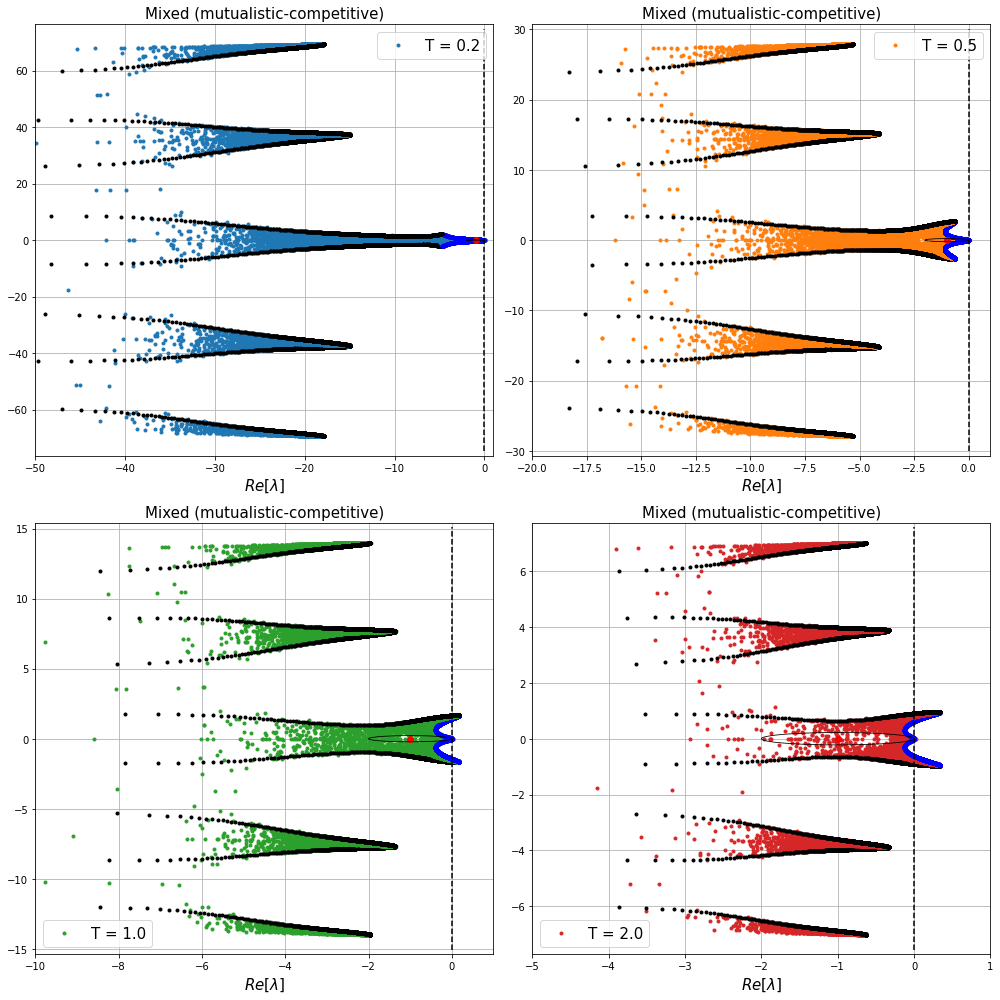

In [101]:
num=5

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(14,14)

Class.sigma = 0.1*np.pi/(np.pi+2)
Class.mix_matrix()
lm = [-50,-20,-10,-5]
for j,T in enumerate(Tvec):
    plt.subplot(2,2,j+1)
    for kk in k_vec:
        evl  = comp_eig_delay(0,Class.M,T,k=kk)
        plt.plot(evl.real, evl.imag,'.',color=color[j])
        for k in range(num):
            Class.mix_matrix()
            evl  = comp_eig_delay(0,Class.M,T,k=kk)
            plt.plot(evl.real, evl.imag,'.',color=color[j])
        f = lambda_funct (np.zeros(len(x)),x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),T,k=kk)
        if kk==0:
            plt.plot(f.real,f.imag,'b.')
        else:
            plt.plot(f.real,f.imag,'k.')
    plt.plot(-Class.d,0,'or')
    plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
    plt.axvline(0,0.01,0.99,ls='--',c='k')
    plt.xlim(left=lm[j],right=1)
    plt.xlabel(f'$Re[\lambda]$',fontsize=15)
    plt.title("Mixed (mutualistic-competitive)",fontsize=15)
    plt.grid()
    plt.legend(labels=[f'T = {T}'],fontsize=15)

fig.tight_layout()
plt.show(fig)

## Profiles

In [39]:
S = 1000       #species - shape matrix
C = 0.1        #connectance
d = 1          #diagonal elements
mu = 0         #mean random coefficients
sigma = 0.1    #sigma random coefficients

complexity = sigma*np.sqrt(S*C)
Class = RMG(S,C,d,mu,sigma)

#circle
theta = np.linspace(0, 2*np.pi, 5000)
r = complexity
x = r*np.cos(theta)
y = r*np.sin(theta)
#ellipse
E = np.sqrt(2/np.pi)*sigma
a = complexity*(1+(E/sigma)**2)
b = complexity*(1-(E/sigma)**2)
c = np.sqrt(a**2-b**2)
r1 = b/np.sqrt(1-(c/a*np.cos(theta))**2)
x1 = r1*np.cos(theta)
y1 = r1*np.sin(theta)

vert = 1.j*complexity*np.linspace(-1,1,1000)
hori = -Class.d + complexity*np.linspace(-1,1,1000)+1.j*10**(-10)

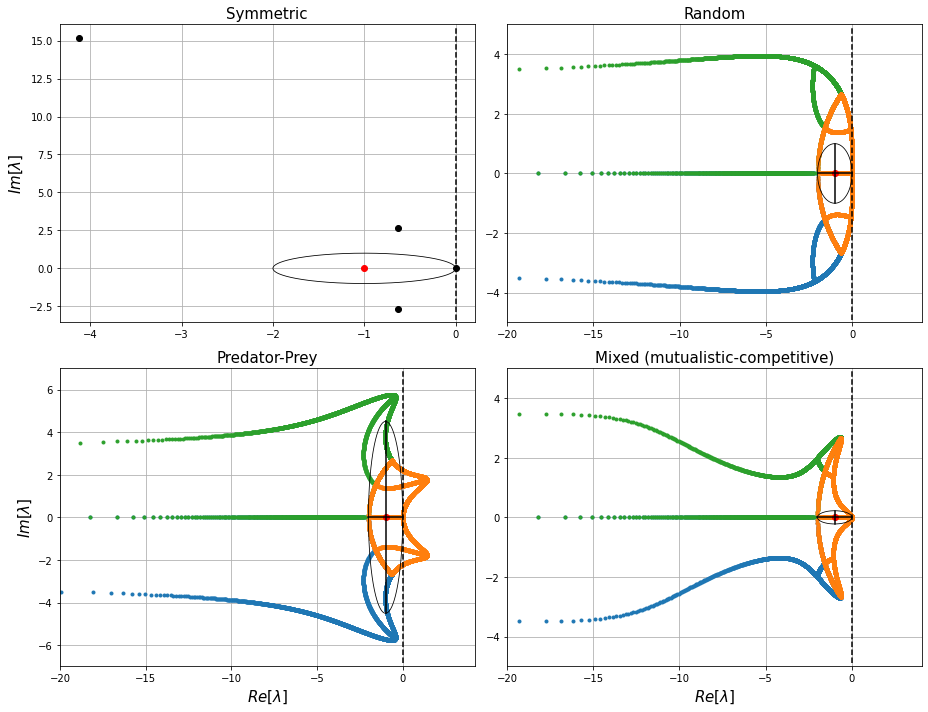

In [42]:
num=0
Tvec1 = [0.5]

fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)

for k in [-1,0,1]:
    for t in Tvec1:
        f = lambda_funct (np.array([0,0]),np.array([-Class.d-complexity,-Class.d+complexity]),t,k=k)
        plt.plot(f.real,f.imag,'ko')
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.grid()

plt.subplot(2,2,2)

for k in [-1,1,0]:
    for t in Tvec1:
        f = lambda_funct (np.zeros(len(x)),x-Class.d+1.j*y,t,k=k)
        f1 = lambda_funct (np.zeros(len(vert)),-Class.d +vert,t,k=k)
        f2 = lambda_funct (np.zeros(len(hori)),hori,t,k=k)
        f3 = lambda_funct (np.zeros(len(hori)),np.conj(hori),t,k=k)
        plt.plot(f.real,f.imag,'.',color=color[k+1])
        plt.plot(f1.real,f1.imag,'.',color=color[k+1])
        plt.plot(f2.real,f2.imag,'.',color=color[k+1])
        plt.plot(f3.real,f3.imag,'.',color=color[k+1])
plt.plot(-Class.d,0,'or')
plt.plot(hori.real,hori.imag,'k-')
plt.plot(-Class.d +vert.real,vert.imag,'k-')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlim(left=-20)
plt.ylim(-5,5)
plt.title("Random",fontsize=15)
plt.grid()

plt.subplot(2,2,3)

for k in [-1,1,0]:
    for t in (Tvec1):
        f = lambda_funct (np.zeros(len(x)),y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),t,k=k)
        f1 = lambda_funct (np.zeros(len(vert)),-Class.d +a*vert*(np.pi/(np.pi-2)),t,k=k)
        f2 = lambda_funct (np.zeros(len(hori)),hori,t,k=k)
        f3 = lambda_funct (np.zeros(len(hori)),np.conj(hori),t,k=k)
        plt.plot(f.real,f.imag,'.',color=color[k+1])
        plt.plot(f1.real,f1.imag,'.',color=color[k+1])
        plt.plot(f2.real,f2.imag,'.',color=color[k+1])
        plt.plot(f3.real,f3.imag,'.',color=color[k+1])
plt.plot(-Class.d,0,'or')
plt.plot(hori.real,hori.imag,'k-')
plt.plot(-Class.d +(a*vert*(np.pi/(np.pi-2))).real,(a*vert*(np.pi/(np.pi-2))).imag,'k-')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlim(left=-20)
plt.ylim(-7,7)
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.grid()

plt.subplot(2,2,4)
for k in [-1,1,0]:
    for t in Tvec1:
        f = lambda_funct (np.zeros(len(x)),x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),t,k=k)
        f1 = lambda_funct (np.zeros(len(vert)),-Class.d +b*vert*(np.pi/(np.pi+2)),t,k=k)
        f2 = lambda_funct (np.zeros(len(hori)),hori,t,k=k)
        f3 = lambda_funct (np.zeros(len(hori)),np.conj(hori),t,k=k)
        plt.plot(f.real,f.imag,'.',color=color[k+1])
        plt.plot(f1.real,f1.imag,'.',color=color[k+1])
        plt.plot(f2.real,f2.imag,'.',color=color[k+1])
        plt.plot(f3.real,f3.imag,'.',color=color[k+1])
plt.plot(-Class.d,0,'or')
plt.plot(hori.real,hori.imag,'k-')
plt.plot(-Class.d +(b*vert*(np.pi/(np.pi+2))).real,(b*vert*(np.pi/(np.pi+2))).imag,'k-')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlim(left=-20)
plt.ylim(-5,5)
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.grid()

fig.tight_layout()
plt.show(fig)

# Comparison of profiles of distributions using W and its approximations

In [102]:
def lambert_approx (evlA,evlB,T):
    z = evlB*T*np.exp(-evlA*T)
    phi = np.log(1+np.sqrt(2*np.e*(z+1/np.e)))
    func = -1+phi+phi**2/6-phi**3/72
    return evlA+func/T

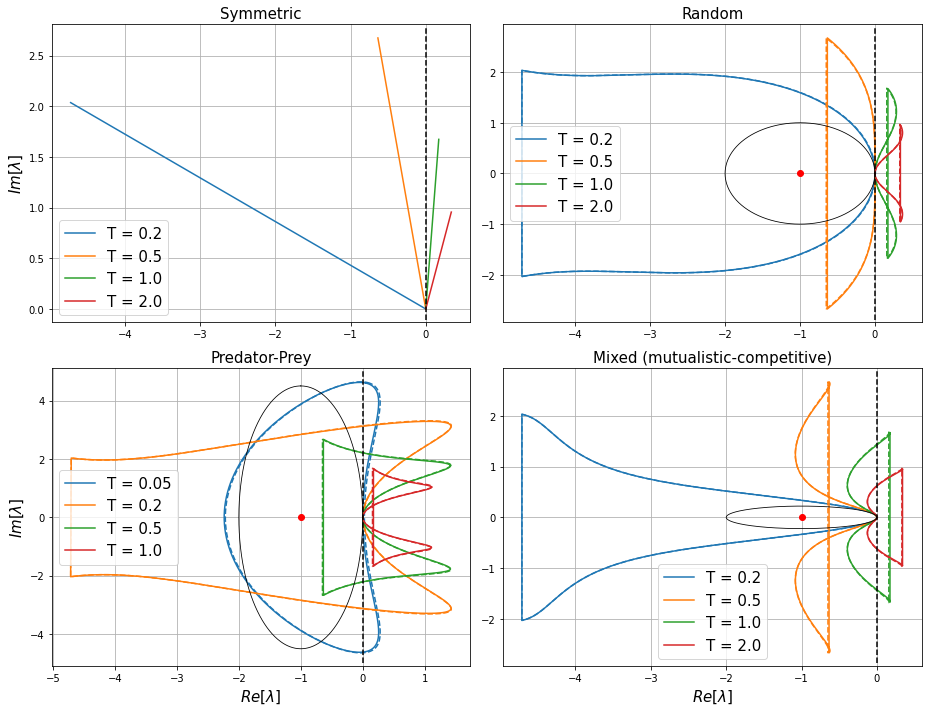

In [113]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
ff = []        
for i,t in enumerate(Tvec):
    f = lambda_funct (np.array([0,0]),np.array([-Class.d-complexity,-Class.d+complexity]),t)
    f1 = lambert_approx (np.array([0,0]),np.array([-Class.d-complexity,-Class.d+complexity]),t)
    plt.plot(f.real,f.imag,'-',color=color[i], label=f'T = {t}')
    plt.plot(f1.real,f1.imag,'--',color=color[i])
    ff += [abs(f-f1)]
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.legend(fontsize=15)
plt.grid()

plt.subplot(2,2,2)
ff0 = []
for i,t in enumerate(Tvec):
    f = lambda_funct (np.zeros(len(x)),x-Class.d+1.j*y,t)
    f1 = lambert_approx (np.zeros(len(x)),x-Class.d+1.j*y,t)
    plt.plot(f.real,f.imag,'-',color=color[i], label=f'T = {t}')
    plt.plot(f1.real,f1.imag,'--',color=color[i])
    ff0 += [abs(f-f1)]
plt.plot(-Class.d,0,'or')
plt.plot(x-Class.d,y,'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.title("Random",fontsize=15)
plt.legend(fontsize=15)
plt.grid()

plt.subplot(2,2,3)
ff1 = []
for i,t in enumerate([0.05]+Tvec[:-1]):
    f = lambda_funct (np.zeros(len(x)),y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),t)
    f1 = lambert_approx (np.zeros(len(x)),y1*(np.pi/(np.pi-2))-Class.d+1.j*x1*(np.pi/(np.pi-2)),t)
    ff1 += [abs(f-f1)]
    plt.plot(f.real,f.imag,'-',color=color[i], label=f'T = {t}')
    plt.plot(f1.real,f1.imag,'--',color=color[i])
plt.plot(-Class.d,0,'or')
plt.plot(y1*(np.pi/(np.pi-2))-Class.d,x1*(np.pi/(np.pi-2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Predator-Prey",fontsize=15)
plt.legend(fontsize=15)
plt.grid()

plt.subplot(2,2,4)
ff2 = []
for i,t in enumerate(Tvec):
    f = lambda_funct (np.zeros(len(x)),x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),t)
    f1 = lambert_approx (np.zeros(len(x)),x1*(np.pi/(np.pi+2))-Class.d+1.j*y1*(np.pi/(np.pi+2)),t)
    plt.plot(f.real,f.imag,'-',color=color[i], label=f'T = {t}')
    plt.plot(f1.real,f1.imag,'--',color=color[i])
    ff2 += [abs(f-f1)]
plt.plot(-Class.d,0,'or')
plt.plot(x1*(np.pi/(np.pi+2))-Class.d,y1*(np.pi/(np.pi+2)),'-k',linewidth=0.8)
plt.axvline(0,0.01,0.99,ls='--',c='k')
plt.xlabel(f'$Re[\lambda]$',fontsize=15)
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.legend(fontsize=15)
plt.grid()

fig.tight_layout()
plt.show(fig)

### Absolute value of the difference of profiles between W and its approximation

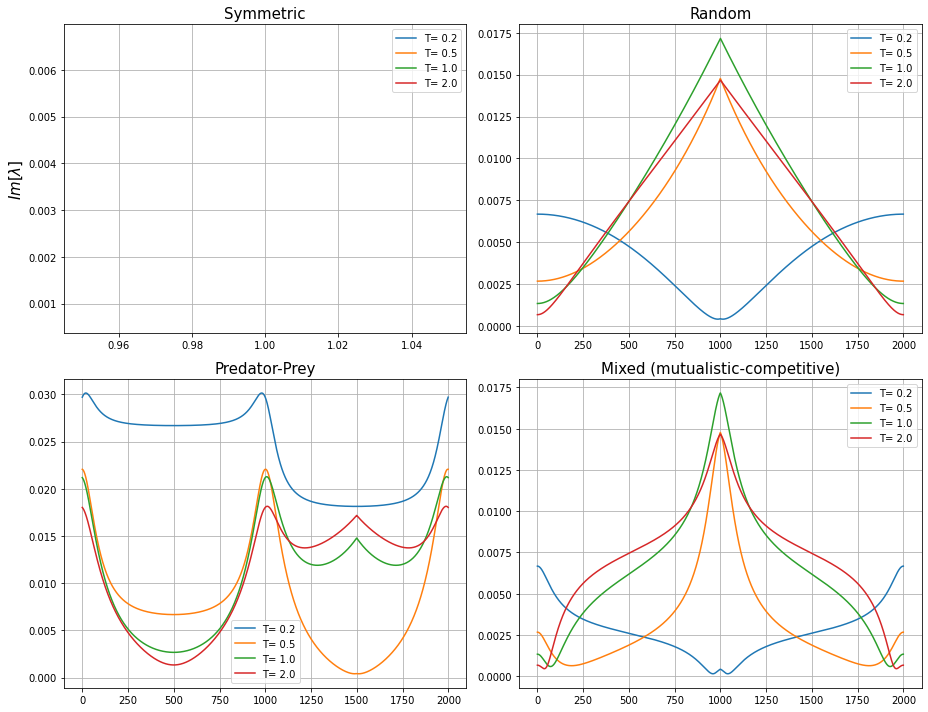

In [107]:
fig, ax = plt.subplots(sharey=True)
fig = plt.gcf()
fig.set_size_inches(13,10)

plt.subplot(2,2,1)
for i,t in enumerate(Tvec):
    plt.plot(np.arange(len(ff[i])),ff[i],'-',label=f'T= {t}')     
plt.ylabel(f'$Im[\lambda]$',fontsize=15)
plt.title("Symmetric",fontsize=15)
plt.grid()
plt.legend()

plt.subplot(2,2,2)
for i,t in enumerate(Tvec):
    plt.plot(np.arange(len(ff0[i])),ff0[i],'-',label=f'T= {t}')
plt.title("Random",fontsize=15)
plt.legend()
plt.grid()

plt.subplot(2,2,3)
for i,t in enumerate(Tvec):
    plt.plot(np.arange(len(ff1[i])),ff1[i],'-',label=f'T= {t}')
plt.title("Predator-Prey",fontsize=15)
plt.grid()
plt.legend()

plt.subplot(2,2,4)
for i,t in enumerate(Tvec):
    plt.plot(np.arange(len(ff2[i])),ff2[i],'-',label=f'T= {t}')
plt.title("Mixed (mutualistic-competitive)",fontsize=15)
plt.grid()
plt.legend()

fig.tight_layout()
plt.show(fig)